# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

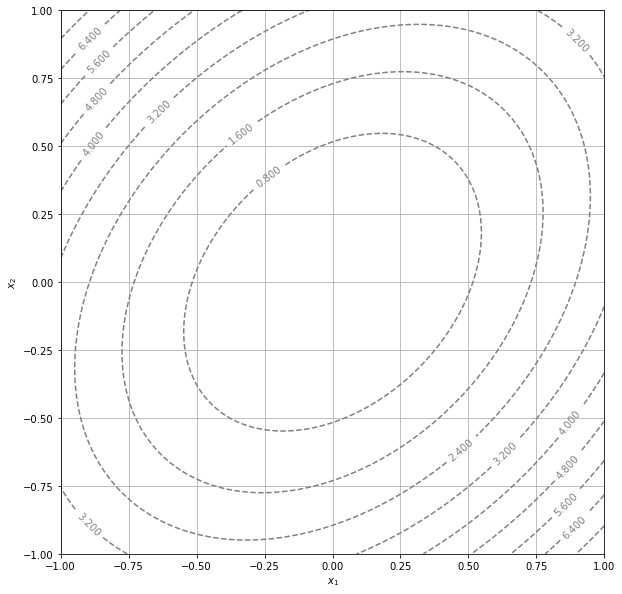

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

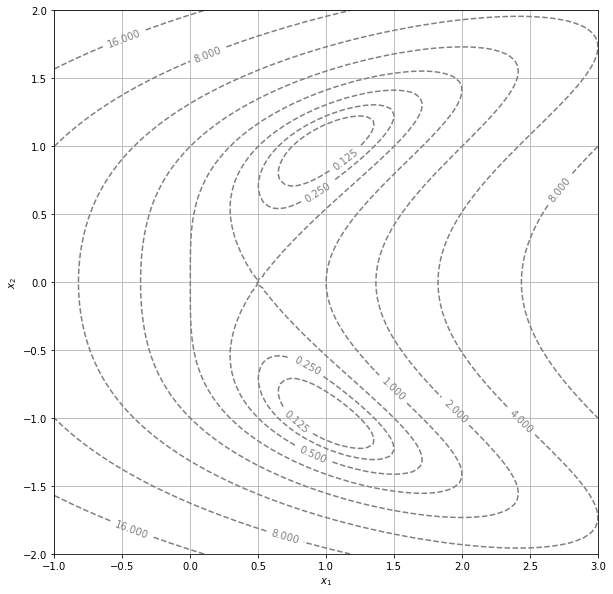

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

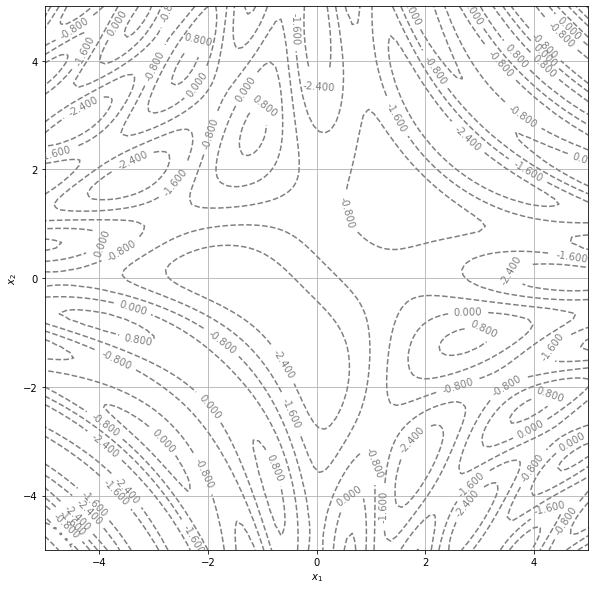

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Réponse 1
Soit C = {$x = (x_{1}, x_{2}) \in \mathbb{R}^2$ tq $f(x_{1},x_{2}) = c$} = $f^{-1}$( {c} ).
C est fermé comme image réciproque du fermé {c} par la fonction f continue. 

De plus si C est non borné alors $\exists (x_{n}) \in C^\mathbb{N}$ tq $\|x_n\| \to +\infty$ quand $n \to +\infty$.

Or $f(x_{n})=c$ et donc par continuité de f, $f(x_{n}) \to c$ quand $n \to +\infty$ ce qui est absurde.
Ainsi, C est borné.

C est fermé et borné donc compact.

#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

#### Réponse 2
$p(x_1,x_2)$ = $det(x_{}- x_{0},\nabla f(x_0))$ ce qui correspond à l'aire (algébrique) du parallélogramme formé par les  vecteurs $x_{}-x_{0}$ et $\nabla f(x_0)$.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Réponse 3
On pose $F: \mathbb{R}^2 \times \mathbb{R} \to \mathbb{R}^2$ qui à $(x_{},t)$ associe $\begin{pmatrix} f(x_{})-c\\ p(x_{})-t\end{pmatrix}$.

$f$ et $p$ sont continûment différentiables donc, par composition, $F$ est également continûment diiférentiable  et $\partial_x F (x,t) = 
\begin{pmatrix}
\partial_1 f(x) & \partial_2 f(x) \\
\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|}
\end{pmatrix}
$ \
Or $det(\partial_x F (x,t))=\partial_1 f(x)\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|}+\partial_2 f(x)\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} $ vaut ${\|\nabla f(x_0)\|} \gt 0$ en $x_0$ (car il est supposé que le gradient de $f$ ne s'annule pas au point $x_0$). Ainsi, il existe un voisinage ouvert $U$ de $x_0$ sur lequel $det(\partial_x F (x,t)) \gt 0$. D'où $\partial_x F$ est inversible sur $U \times \mathbb{R}$.\
De plus, $F(x_0,0)=(0,0)$

Alors d'après le théorème des fonctions implicites, il existe un voisinage ouvert $V$ de $x_0$ et $\varepsilon \gt 0$ tels que $V \times \left]-\varepsilon,\varepsilon \right[ \subset U \times \mathbb{R}$ et une unique fonction implicite $\gamma : \left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ continûment différentiable, telle que $\forall (x,t) \in V \times \left]-\varepsilon,\varepsilon \right[$,
$$
F(x,t)=0 \Leftrightarrow x=\gamma(t)
$$
C'est-à-dire:
$$
\begin{cases}
f(x_1,x_2) = c \\
t = p(x_1, x_2)
\end{cases}
\Leftrightarrow
(x_1, x_2) = \gamma(t)
$$

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

#### Réponse 4
Le théorème des fonctions implicites indique également que $\forall t \in \left]-\varepsilon,\varepsilon \right[, \gamma'(t) = -(\partial_x F (x,t))^{-1}.\partial_t F (x,t)$ avec $\partial_t F (x,t)=\begin{pmatrix} 0\\ -1\end{pmatrix} = -(\partial_x F (x,t)).\gamma'(t) \neq 0$ donc $\forall t \in \left]-\varepsilon,\varepsilon \right[,\gamma'(t) \neq  \begin{pmatrix} 0\\ 0\end{pmatrix}$.

Par ailleurs, $\forall t \in \left]-\varepsilon,\varepsilon \right[, f(\gamma(t)) = c \Rightarrow \forall t \in \left]-\varepsilon,\varepsilon \right[,   (f(\gamma(t)))' = 0 \Rightarrow \forall t \in \left]-\varepsilon,\varepsilon \right[, \left \langle \gamma'(t) | \nabla f(\gamma(t)) \right \rangle = 0 \Rightarrow \forall t \in \left]-\varepsilon,\varepsilon \right[, \gamma'(t)$ orthogonal à $\nabla f(\gamma(t))$.

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

#### Réponse 5
La fonction Newton doit permettre d'identifier les coordonnées d'un zéro de la fonction $F$ avec une grande précision. En effet, l'idée est ici, mais aussi et surtout dans les programmes suivants, de ne se déplacer que d'une courte distance à partir du point $x_0$ initial, dont l'image par $F$ est donc proche de 0. Ainsi, il est nécessaire de choisir une valeur de espilon relativement faible pour aboutir à des résulats précis.
Toutefois, il est nécessaire de converger vers la réponse en moins de 100 étapes. Or, après plusieurs modifications de la valeur de epsilon, nous nous sommes rendus compte qu'au delà de $10^{-15}$, ce nombre d'étapes ne suffit plus à fournir un résultat dans l'ensemble des algorithmes de ce devoir. Ainsi, il s'agit d'une valeur seuil liée aux fonctions étudiées. C'est pourquoi nous prenons une valeur bien supérieure à celle-ci afin d'assurer la convergence en un nombre raisonnable d'étapes, et ce quelle que soit la fonction étudiée.

In [14]:
N = 100
eps = 10**(-10)

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(f,x0,y0,eps=eps,N=N):
    X=np.array([x0,y0])
    def J_f(x,y):
        return F(f,x,y)
    j=J(J_f)
    for i in range(N):
        X = X-np.dot(np.linalg.inv(j(x0,y0)),F(f,x0,y0))
        x, y = X[0], X[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else: 
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

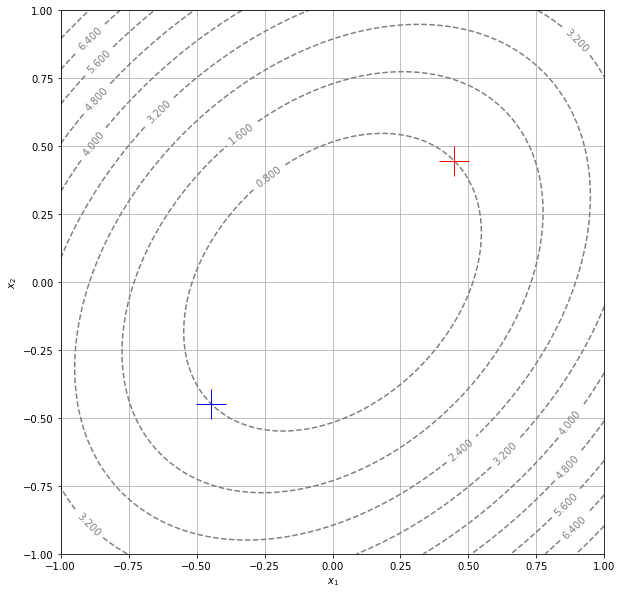

In [16]:
def F(f, x, y):
    return np.array([f(x,y)-0.8,x-y])
display_contour(
    f1, 
    x = np.linspace(-1.0, 1.0, 100), 
    y = np.linspace(-1.0, 1.0, 100), 
    levels = 10 # 10 levels, automatically selected
)

X = Newton(f1,0.8,0.8)
plt.plot(X[0],X[1],'r+',markersize=30)

Y = Newton(f1,-0.2,-0.2)
plt.plot(Y[0],Y[1],'b+',markersize=30)



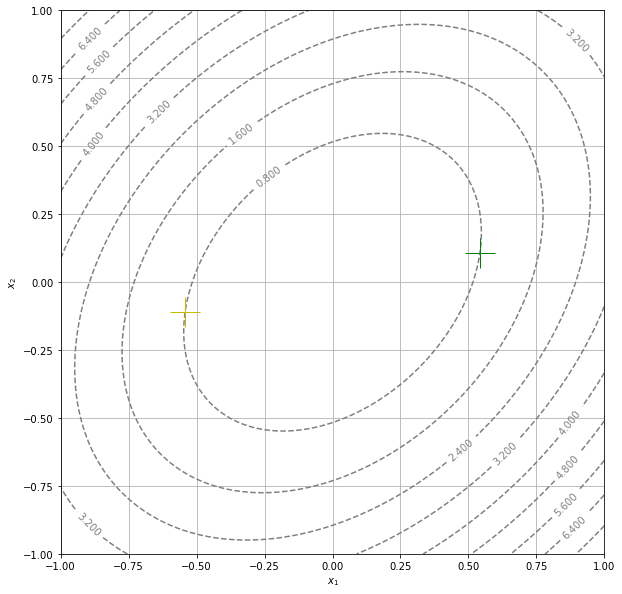

In [17]:
def F(f,x,y):
    return np.array([f(x,y)-0.8,x-5*y])
display_contour(
    f1, 
    x = np.linspace(-1.0, 1.0, 100), 
    y = np.linspace(-1.0, 1.0, 100), 
    levels = 10 # 10 levels, automatically selected
)

X = Newton(f1,0.8,0.8)
plt.plot(X[0],X[1],'g+',markersize=30)

Y = Newton(f1,-0.2,-0.2)
plt.plot(Y[0],Y[1],'y+',markersize=30)


### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

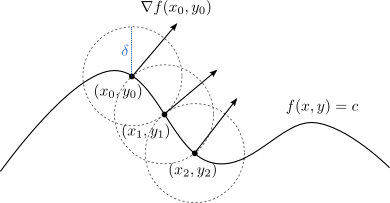

#### Réponse 6
Il est nécessaire d'introduire la condition $\sqrt{(x_{1}-x_{0})^2-(y_{1}-y_{0})^2}< \delta$ dans la définition de la fonction F en modifiant la deuxième  coordonnée. Pour cela, la fonction Fbis devra prendre en paramètres les coordonnées du point précedent ainsi que celle de delta. 
Aussi, pour s'assurer que le point trouvé se trouve bien "à droite" de $\nabla f(x_0, y_0)$ il suffit de prendre comme point de départ pour la fonction Fbis, un point se situant à au moins $\delta$ dans la  direction de $\nabla f(x_0, y_0) \wedge (0,0,1)$ dans $\mathbb{R}^3$ du point $(x_{0},y_{0})$.

In [18]:
def Fbis(f,x,y,c,x0,y0,delta):
    return np.array([f(x,y)-c,np.sqrt((x-x0)**2+(y-y0)**2)-delta]) ### permet de garantir la condition: distance(X,X0)==delta

def Newtonbis(f,x0,y0,delta,s,t,c,eps=eps,N=100): ### Cela n'était pas forcément necessaire, il aurait été possible de se contenter de la fonction level_curve
    X = np.array([x0,y0])
    def J_f(g,h):
        return Fbis(f,g,h,c,s,t,delta)
    j = J(J_f)
    for i in range(N):
        X = X-np.dot(np.linalg.inv(j(x0,y0)),J_f(x0,y0))
        x, y = X[0], X[1]
        if np.sqrt((X[0] - x0)**2 + (X[1] - y0)**2) <= eps:
            return np.array([X[0], X[1]])
        x0, y0 = x, y
    else: 
        raise ValueError(f"no convergence in {N} steps.")

def level_curve(f, x0, y0, delta=0.1, N=101, eps=eps):
    c=f(x0,y0)
    Result = [[x0],[y0]] 
    for k in range(N):
        grad_f0 = grad(f)(x0,y0)
        perp = np.cross(np.array([grad_f0[0],grad_f0[1],0]),np.array([0,0,1]))
        Norme = np.linalg.norm(perp)
        x , y = x0 + perp[0]/Norme*delta, y0 + perp[1]/Norme*delta ### décalage d'un vecteur de norme delta vers la droite
        L = Newtonbis(f,x,y,delta,x0,y0,c)
        x0 , y0 = L[0] , L[1]
        Result[0].append(L[0])
        Result[1].append(L[1])
    return(Result)### Resultat sous forme d'une liste de 2 listes de longueur N 

           


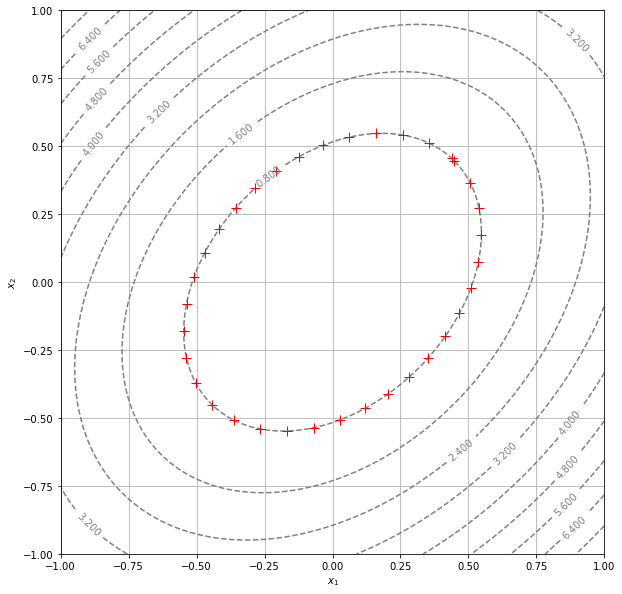

In [19]:
L = level_curve(f1,0.4472135954999579, 0.4472135954999579)
X = []
Y = []
for i in range(35):
    X.append(L[0][i])
    Y.append(L[1][i])
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.plot(X,Y,'r+',markersize=10)

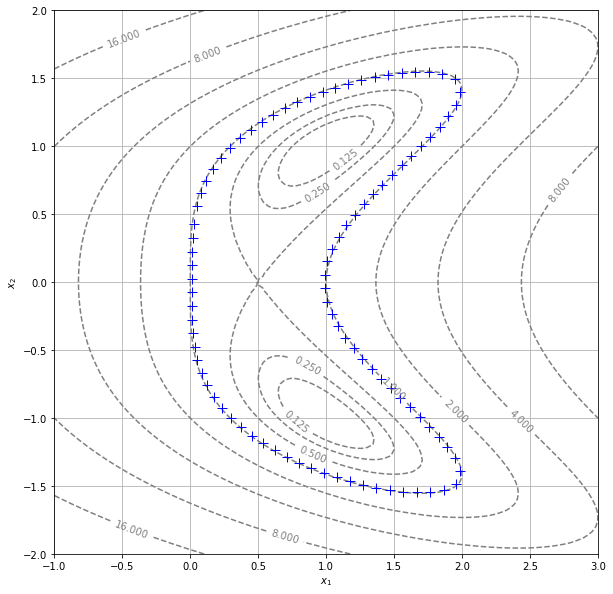

In [20]:
L = level_curve(f2, 0.05, 0.56)
X = []
Y = []
for i in range(94):
    X.append(L[0][i])
    Y.append(L[1][i])
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.plot(X,Y,'b+',markersize=10)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

#### Réponse 7
Le cas observé dans la fonction de Rosenbrock est relativement rare. En effet, il correspond à l'annulation du gradient à trois reprises localement. Ainsi, il est peu probable que le premier segement intersecté ne soit pas le premier créé via la fonction level_curve. C'est pourquoi, en étant raisonnablement optimiste, il semble judicieux de se contenter de tester l'intersection du dernier segment uniquement avec le premier segment déjà produit.

In [21]:
def level_curvebis(f, x0, y0, delta=0.1, N=100, eps=eps):
    c = f(x0,y0)
    Result = [[x0],[y0]]
    for k in range(N):
        grad_f0 = grad(f)(x0,y0)
        perp = np.cross(np.array([grad_f0[0],grad_f0[1],0]),np.array([0,0,1]))
        Norme = np.linalg.norm(perp)
        x , y = x0 + perp[0]/Norme*delta, y0 + perp[1]/Norme*delta ### prochain point de départ 
        L = Newtonbis(f,x,y,delta,x0,y0,c)
        x0 , y0 = L[0] , L[1]
        Result[0].append(L[0])
        Result[1].append(L[1])
        if np.sqrt((Result[0][-1]-Result[0][0])**2+(Result[1][-1]-Result[1][0])**2)<delta-eps: ### il existe toutefois un cas problématique
            return(Result)  ### on compare juste avec le premier point 
    return(Result)

In [22]:
def Intersect(P1,P2,P3,P4):

    if (max(P1[0],P2[0]) < min(P3[0],P4[0])): # Pas d'intersection possible car intervalles disjoints.
        return False

    if P1[0]-P2[0] != 0 and P3[0]-P4[0] !=0 :
        A1 = (P1[1]-P2[1])/(P1[0]-P2[0])  # y = ax+b
        A2 = (P3[1]-P4[1])/(P3[0]-P4[0])
        b1 = P1[1]-A1*P1[0]
        b2 = P3[1]-A2*P3[0]
        if A1==A2 : # Segments parrallèles
            return(False)
        else : 
            Xa = (b2 - b1) / (A1 - A2) ## abscisse de l'intersection
            if ( (Xa < max( min(P1[0],P2[0]), min(P3[0],P4[0]) )) or (Xa > min( max(P1[0],P2[0]), max(P3[0],P4[0]) )) ):
                return False #L'abscisse de l'intersection doit être dans le domaine de définition des segments
            else : 
                return True
    else : #pas utile avec approx flottant 
        if (P1[0]-P2[0]==0 and P3[0]-P4[0]==0):
            return False
        else :
            if P1[0]-P2[0]==0 : # on a x = c
                X = P1[0]
                Y =  (P3[1]-P4[1])/(P3[0]-P4[0])*P1[0] + P3[1]-A2*P3[0]
            else :
                X = P3[0]
                Y = (P1[1]-P2[1])/(P1[0]-P2[0])*P3[0]+ P1[1]-A1*P1[0]
            if (min(P1[0],P2[0])<= X<= max(P1[0],P2[0]) and min(P3[0],P4[0])<= X<= max(P3[0],P4[0])) and (min(P1[1],P2[1])<= Y<= max(P1[0],P2[0]) and min(P3[1],P4[1])<= Y<= max(P3[1],P4[1])):
                return True
            else :
                return False

def level_curvebis(f, x0, y0, delta=0.1, N=100, eps=eps):
    c = f(x0,y0)
    Result = [[x0],[y0]]
    for k in range(N):
        grad_f0 = grad(f)(x0,y0)
        perp = np.cross(np.array([grad_f0[0],grad_f0[1],0]),np.array([0,0,1]))
        Norme = np.linalg.norm(perp)
        x , y = x0 + perp[0]/Norme*delta, y0 + perp[1]/Norme*delta ### prochain point de départ 
        L = Newtonbis(f,x,y,delta,x0,y0,c)
        x0 , y0 = L[0] , L[1]
        Result[0].append(L[0])
        Result[1].append(L[1])
        if k>=1 and Intersect([Result[0][0],Result[1][0]],[Result[0][1],Result[1][1]],[Result[0][-1],Result[1][-1]],[Result[0][-2],Result[1][-2]]):
            return(Result)  ### on compare juste avec le premier point 
    return(Result)

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

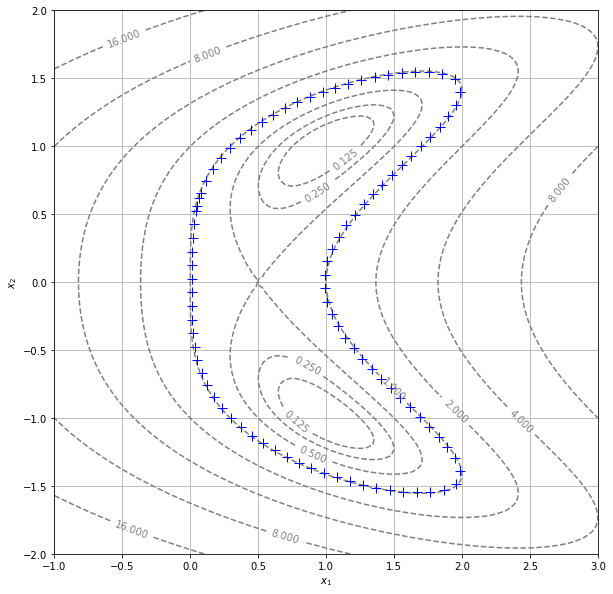

In [23]:
L = level_curvebis(f2, 0.05, 0.56)
X = []
Y = []
for i in range(len(L[0])): ###changement...
    X.append(L[0][i])
    Y.append(L[1][i])
display_contour(
    f2, 
    x = np.linspace(-1.0, 3.0, 100), 
    y = np.linspace(-2.0, 2.0, 100), 
    levels = [2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.plot(X,Y,'b+',markersize=10)

### à un point près, on remarque que la fonction s'est arrétée au bon endroit

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Réponse 8
On cherche à déterminer les coefficients $a, b, c, d, e, f$ solutions du problèmes et les expliciter en fonction de $P_1$, $P_2$, $u_1$ et $u_2$.
On note leur coordonnées : 
$P_1 = (x_{p1}, y_{p1})$ \;
$P_2 = (x_{p2}, y_{p2})$ \;
$u_1 = (x_{u1}, y_{u2})$ \;
$u_2 = (x_{u2}, y_{u2})$ 

On a les conditions : $\gamma(0) = P_1 \Leftrightarrow 
\left\{\begin{matrix}
a=x_{p1}\\ 
d=y_{p1}
\end{matrix}\right.$
et $\gamma(1) = P_2 \Leftrightarrow \left\{\begin{matrix}
a+b+c=x_{p2}\\ 
d+e+f=y_{p2}
\end{matrix}\right.$, que l'on note $(1)$.

De plus on sait que   $\gamma'(0)$  et $\gamma'(1)$  sont respectivement dans la même direction et le même sens que $u_1$ et $u_2$, c'est-à-dire qu'il existe
$\alpha$ et $\beta$ des réels positifs tels que: $\left\{\begin{matrix}
\gamma'(0)=\alpha u_1\\ 
\gamma'(1)=\beta u_2
\end{matrix}\right.$
$\Leftrightarrow \left\{\begin{matrix}
b=\alpha x_{u1}\\ 
e=\alpha y_{u1}\\
b + 2c = \beta x_{u2}\\
e +2f = \beta y_{u2}
\end{matrix}\right.$ $\Leftrightarrow \left\{\begin{matrix}
b=\alpha x_{u1}\\ 
e=\alpha y_{u1}\\
\alpha x_{u1} + 2c = \beta x_{u2}\\
\alpha y_{u1} +2f = \beta y_{u2}
\end{matrix}\right.$  conditions que l'on note $(2)$.

$ (1)\Leftrightarrow \left\{\begin{matrix}
c= x_{P2}-x_{P1}-\alpha x_{u1}\\ 
f= y_{P2}-y_{P1}-\alpha y_{u1}
\end{matrix}\right. 
\Leftrightarrow \left\{\begin{matrix}
\alpha x_{u1} + 2x_{P2}-2x_{P1}-2\alpha x_{u1} = \beta x_{u2}\\ 
\alpha y_{u1} +2y_{P2}-2y_{P1}-2\alpha y_{u1} = \beta y_{u2}
\end{matrix}\right.
\Leftrightarrow \left\{\begin{matrix}
2x_{P2}-2x_{P1}-\alpha x_{u1} = \beta x_{u2}\\ 
2y_{P2}-2y_{P1}-\alpha y_{u1} = \beta y_{u2}
\end{matrix}\right.
\Leftrightarrow \left\{\begin{matrix}
\alpha x_{u1} + \beta x_{u2} = 2(x_{P2}-x_{P1})\\ 
\alpha y_{u1} + \beta y_{u2} = 2(y_{P2}-y_{P1})
\end{matrix}\right.$
Pour que ce système ait une solution, il faut que le déterminant de la matrice $ \begin{pmatrix}
x_{u1} & x_{u2}\\ 
y_{u1} & y_{u2}
\end{pmatrix}$ soit non nul, c'est-à-dire :
$ \left | \begin{pmatrix}
x_{u1} & x_{u2}\\ 
y_{u1} & y_{u2}
\end{pmatrix} \right | = x_{u1}y_{u2}- x_{u2}y_{u1} \neq 0 $, ce qui revient à dire que $u_1$ et $u_2$ ne sont pas
colinéaires.
Dans ce cas-là, on résout le système et on trouve comme forme de solution :
$\alpha = 2 \frac{\left | \begin{pmatrix}
x_{P2}-x_{P1} & x_{u2}\\ 
y_{P2}-y_{P1} & y_{u2}
\end{pmatrix} \right |}{det(u1,u2)}=2 \frac{y_{u2}(x_{P2}-x_{P1})-x_{u2}(y_{P2}-y_{P1})}{x_{P1}y_{P2}- x_{P2}y_{P1}} $ et 
$
\beta = 2 \frac{\left | \begin{pmatrix}
 x_{u1} &x_{P2}-x_{P1}\\ 
 y_{u1} &y_{P2}-y_{P1}
\end{pmatrix} \right |}{det(u1,u2)}=2 \frac{x_{u1}(y_{P2}-y_{P1})-y_{u1}(y_{P2}-y_{P1})}{x_{P1}y_{P2}- x_{P2}y_{P1}}$

Ainsi, $\left\{\begin{matrix}
a=x_{p1}\\ 
b=\alpha x_{u1} \\
c=\frac{\beta x_{u2} - \alpha x_{u1}}{2} \\
d=y_{p1}\\
e=\alpha y_{u1} \\
f =\frac{\beta y_{u2} - \alpha y_{u1}}{2} \\
\end{matrix}\right.$

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [24]:
### u1 et u2 non colinéaires 
def gamma(t,P1,P2,u1,u2):  
    A = np.array([[1,1,0,0],[0,0,1,1],[u1[1],0,-u1[0],0],[u2[1],2*u2[1],-u2[0],-2*u2[0]]])
    m = np.array([P2[0]-P1[0],P2[1]-P1[1],0,0])
    if np.linalg.det(A)!=0:
        V = np.linalg.solve(A,m)
        a, b, c, d, e, f = P1[0], V[0], V[1], P1[1], V[2], V[3]
        gammaprime0 = np.array([b,e])
        gammaprime1 = np.array([b+2*c,e+2*f])
        if (np.dot(gammaprime0,u1)-np.linalg.norm(gammaprime0)*np.linalg.norm(u1)==0) and (np.dot(gammaprime1,u2)-np.linalg.norm(gammaprime1)*np.linalg.norm(u2)==0):
            return([a+b*t+c*t**2 , d+e*t+f*t**2])
        else:
            return([(P2[0]-P1[0])*t+P1[0], (P2[1]-P1[1])*t+P1[1]])
    else:
        return([(P2[0]-P1[0])*t+P1[0], (P2[1]-P1[1])*t+P1[1]])

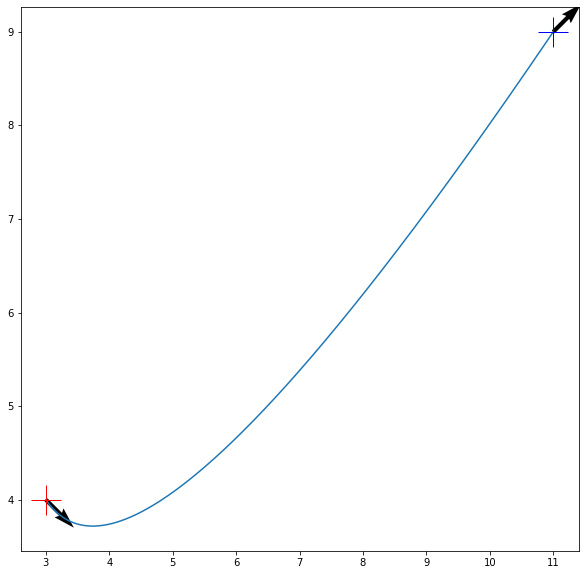

In [25]:
t=np.linspace(0,1,1000)
G=gamma(t,[3,4],[11,9],[1,-1],[1,1])
plt.plot(G[0],G[1])
plt.plot(3,4, 'r+', markersize=30)
plt.plot(11,9,'b+', markersize=30)
plt.quiver(3,4,1,-1,scale=20)
plt.quiver(11,9,1,1,scale=20)

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [26]:
def level_curvefinal(f, x0, y0, oversampling, delta=0.1, N=100, eps=eps):
    c = f(x0,y0)
    Result = [[x0],[y0]]
    RES = [[],[]]
    for k in range(N):
        grad_f0 = grad(f)(x0,y0)
        perp = np.cross(np.array([grad_f0[0],grad_f0[1],0]),np.array([0,0,1]))
        Norme = np.linalg.norm(perp)
        x , y = x0 + perp[0]/Norme*delta, y0 + perp[1]/Norme*delta ### prochain point de départ 
        L = Newtonbis(f,x,y,delta,x0,y0,c)
        x0 , y0 = L[0] , L[1]
        Result[0].append(L[0])
        Result[1].append(L[1]) 
        if np.sqrt((Result[0][-1]-Result[0][0])**2+(Result[1][-1]-Result[1][0])**2)<delta-10**(-8): ### la condition ne se produira jamais 2fois
            break  
    if oversampling == 1:
        return(Result)
    else:
        Res = Result.copy()
        T = np.linspace(0,1,oversampling+1)
        for k in range(1,len(Result[0])-2):
            u1 = [Result[0][k]-Result[0][k-1],Result[1][k]-Result[1][k-1]]
            u2 = [Result[0][k+2]-Result[0][k+1],Result[1][k+2]-Result[1][k+1]]
            P1 = [Result[0][k],Result[1][k]]
            P2 = [Result[0][k+1],Result[1][k+1]]
            Points = gamma(T,P1,P2,u1,u2)
            Res[0] = Res[0]+list(Points[0][1:-1])
            Res[1] = Res[1]+list(Points[1][1:-1])
        u1 = [Result[0][-2]-Result[0][-3],Result[1][-2]-Result[1][-3]]
        u2 = [Result[0][0]-Result[0][-1],Result[1][0]-Result[1][-1]]
        P1 = [Result[0][-2],Result[1][-2]]
        P2 = [Result[0][-1],Result[1][-1]] ### entre les points "-2" et "-1"
        Points = gamma(T,P1,P2,u1,u2)
        Res[0] = Res[0]+list(Points[0][1:-1])
        Res[1] = Res[1]+list(Points[1][1:-1])
        u1 = [Result[0][0]-Result[0][-1],Result[1][0]-Result[1][-1]]
        u2 = [Result[0][2]-Result[0][1],Result[1][2]-Result[1][1]]
        P1 = [Result[0][0],Result[1][0]]
        P2 = [Result[0][1],Result[1][1]] ### entre les points "0" et "1"
        Points = gamma(T,P1,P2,u1,u2)
        Res[0] = Res[0]+list(Points[0][1:-1])
        Res[1] = Res[1]+list(Points[1][1:-1])
        ###On ne met pas dans la boucle pour ne pas prendre en compte l'intervalle entre les points "0" et "-1".
    return(Res)

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

True

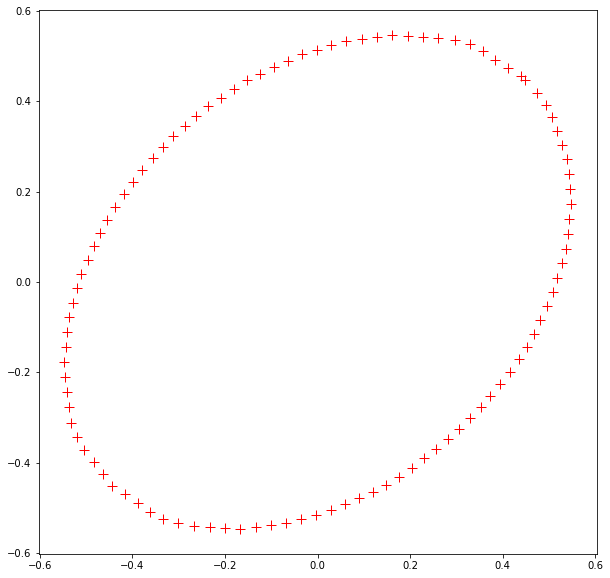

In [27]:
L = level_curvefinal(f1,0.4472135954999579, 0.4472135954999579,3)
X = []
Y = []
for i in range(len(L[0])):
    X.append(L[0][i])
    Y.append(L[1][i])
plt.plot(X,Y,'r+',markersize=10)
len(L[0]) == 35*3-2 ### 35 points initiaux --> 34 intervalles

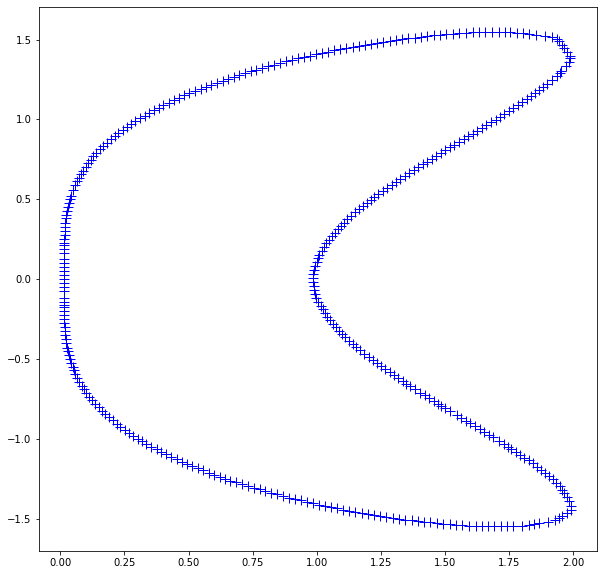

In [28]:
L=level_curvefinal(f2, 0.05, 0.56,4)
X=[]
Y=[]
for i in range(len(L[0])):
    X.append(L[0][i])
    Y.append(L[1][i])
plt.plot(X,Y,'b+',markersize=10)